# Benchmarking 

It is important to know how well our program performs.
- Before starting any work, we can explore the bottlenecks and causes for it to be running slowly
- During and after working on parallelization, we want to make sure that our work did have an impact on the execution speed of the program.

For this, we use benchmarking. We will see in this episode how to do benchmarking and answer two questions:
- How do we know if our program runs faster? 
- How do we learn about efficiency?


### A first example with Dask

Before we jump into parallelization, let's first understand what is going on under the hood on our computers.

For this, let's open a system monitor.
- On linux, this is the `system monitor`
- On Mac, `activity monitor`
- On windows, `task manager` (?)

<mark>Explain the system monitor (?)</mark>


Then we will compare the following code examples
- Start low, with `10**7`, increase slowly. Otherwise your computer may slow down substantially or crash.
- But the task needs to be heavy enough for us to see anything going on.

In [12]:
import numpy as np 
result = np.arange(10**9).sum()

We see 8 CPUs in total, and two of them are used when we execute the cell.

Let's now try with Dask. 

<mark>What is dask?</mark>

The API for dask arrays is similar to that of numpy.

In [11]:
import dask.array as da 


In [13]:
work = da.arange(10**9).sum()
result = work.compute()

We see that the work is distributed to *all* CPUs, and each of them is only 80% occupied during the execution.
Thus, dask **executes computation in parallel**, while the numpy approach does it in a serial manner (refer back to the example from the introduction).

We also see a much smaller memory requirement when using dask (the bump for the memory line in the middle)

**Making this more practical**
- We can use python magic functions, that start with `%%`, to see how fast our program runs.
- It does not change any other aspect of the program

In [14]:
%%time 
np.arange(10**9).sum()

CPU times: user 869 ms, sys: 699 ms, total: 1.57 s
Wall time: 1.57 s


499999999500000000

**Explain the CPU times: user, sys, total**

It'd be nice to have a more rigorous measure than just this single run -- which we can do with the `%%timeit`, which repeats the command multiple times to get an average running time. 
Moreover, `%%timeit` ignores the time it takes to set up the problem (what is that in this case?), thus only measuring the performance of the code in the cell.

In [15]:
%%timeit 
np.arange(10**9).sum()

1.57 s ± 7.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can also store the output of `%%timeit` in a python variable and use it later, as follows

In [16]:
time = %timeit -o np.arange(10**9).sum()
print(f"Time taken: {time.average:.4f}s")

1.57 s ± 21.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Time taken: 1.5725s


To do 
- one vs two %?

This is nice, but does not tell us anything about how much and how efficiently we use memory

### Memory profiling

- **benchmarking**: the act of systematically testing performance under different conditions. Different conditions = different hardware, but also different way of implementing a solution in software (as above with the example of dask and numpy)
- **profiling**: analysing which parts of a program contribute to the total performance and identifying bottlenecks


Let us now compare the memory usage between the serial and the parallel versions of the code from above

In [19]:
from memory_profiler import memory_usage
import matplotlib.pyplot as plt 

def sum_with_numpy():
    # serial implementation
    np.arange(10**9).sum()

def sum_with_dask():
    # parallel implementation
    work = da.arange(10**9).sum() ## XXX what does this do? check documentation
    work.compute()

The documentation for `memory_usage` is here: https://pypi.org/project/memory-profiler/
- the output is memory usage in megabytes, so below we're using 1GB vs 8 GB of memory


In [22]:
memory_numpy = memory_usage(sum_with_numpy, interval=0.01)


In [21]:
memory_dask = memory_usage(sum_with_dask, interval=0.01)

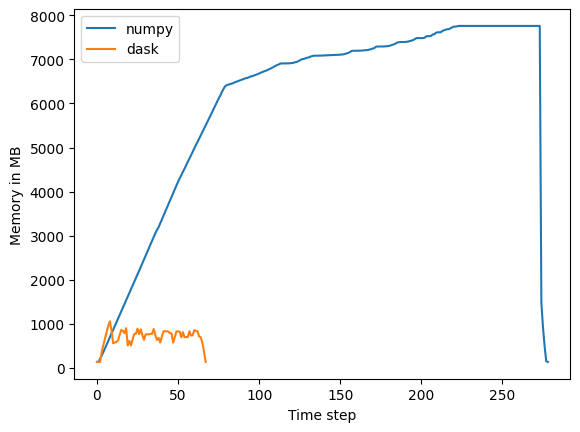

In [24]:
plt.plot(memory_numpy, label="numpy")
plt.plot(memory_dask, label="dask")
plt.xlabel("Time step")
plt.ylabel("Memory in MB")
plt.legend()
plt.show()

<mark>Exercise</mark>
Why is the dask solution more memory-efficient?

**Solution**
Dask uses chunks. Thus, it splits the large array into samller parts and so the data is never entirely in memory.

In [35]:
work = da.arange(10**9)
work

dask.array<arange, shape=(1000000000,), dtype=int64, chunksize=(15625000,), chunktype=numpy.ndarray>

How does this square up with the memory usage of about 1 GB? 
- one chunk is 119 MB 
- we have 8 CPUs, so at a single time we have around 8 * 119MB data in memory
- this makes around 950 MB, roughly in line with the figure above

## Using many cores

- We can decrease the running time of the program by using more than one core -- as we've seen in the example above 
- *How many cores do I have?*

In [39]:
import psutil 
N_physical_cores = psutil.cpu_count(logical=False)
N_logical_cores = psutil.cpu_count(logical=True)
print(f"The number of physical/logical cores is {N_physical_cores}/{N_logical_cores}")

# cpu_count gives the number of cores; either logical or physical

The number of physical/logical cores is 4/8


The difference between logical and physical cores comes from *hyperthreading*. This means that a single physical CPU core can execute multiple threads ($\approx$ instructions) at the same time -- typically 2. 

Technically, each core has 2 processors, and they are able to execute threads independently. 

**what is a thread?**
This can have unexpected effects on how performance scales. Let's see the example below

In [54]:
help(range)

Help on class range in module builtins:

class range(object)
 |  range(stop) -> range object
 |  range(start, stop[, step]) -> range object
 |  
 |  Return an object that produces a sequence of integers from start (inclusive)
 |  to stop (exclusive) by step.  range(i, j) produces i, i+1, i+2, ..., j-1.
 |  start defaults to 0, and stop is omitted!  range(4) produces 0, 1, 2, 3.
 |  These are exactly the valid indices for a list of 4 elements.
 |  When step is given, it specifies the increment (or decrement).
 |  
 |  Methods defined here:
 |  
 |  __bool__(self, /)
 |      True if self else False
 |  
 |  __contains__(self, key, /)
 |      Return key in self.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(self, key, /)
 |      Return self[key].
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __hash

In [92]:
x = []
n_cores = range(1, 16, 1)
for n in n_cores:
    time_taken = %timeit -r 1 -o da.arange(5*10**7).sum().compute(num_workers=n)
    x.append(time_taken.average)

77.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
43 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
44.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
32.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
31.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
32.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
33.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
34.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
34.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
33.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
34.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
33.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
35.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
32.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
34.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops eac

<Axes: xlabel='n'>

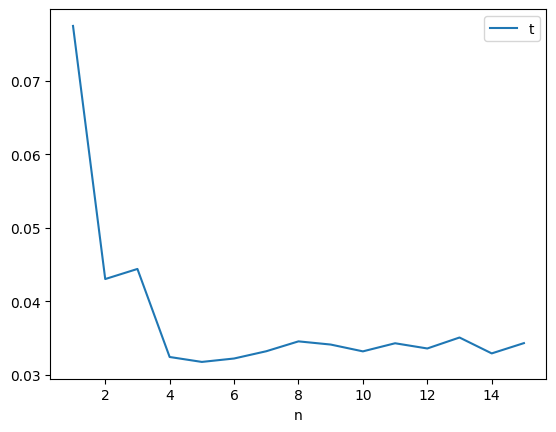

In [93]:
import pandas as pd
data = pd.DataFrame({"n": n_cores, "t": x})
data.set_index("n").plot()

**Discussion**
- Because of hyperthreading, the running time is increasing when using more than 4 cores. Or at least there is not much more to gain.
- On most hardware architectures, it does not make much sense to use more workers than we have cores
- But whether the running time increases or not when using more than the number of physical cores perhaps depends on the specific system architecture. When it's better optimized, the loss in performance from using too many workers is smaller.

**Key points**
- understanding performance is often non-trivial 
- memory and speed are equally important
- measuring is knowing